In [15]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
%matplotlib inline
from scipy.signal import resample

In [16]:
class BedPlateModel:
    def __init__(self, 
                 Lx=2.0, Ly=1.0, h=0.02,
                 E=10e9, rho=600, nu=0.3,
                 damping_ratio=0.05,
                 patch_size=(0.2, 0.2)):  # Contact patch size (ax, ay)
        """
        Simply supported rectangular thin plate + modal superposition
        Input: contact patch total force F(t) [N]
        Output: sensor point velocity v(t) [m/s]
        """
        self.Lx, self.Ly, self.h = Lx, Ly, h
        self.E, self.rho, self.nu = E, rho, nu
        self.zeta = damping_ratio
        self.ax, self.ay = patch_size

        # Bending stiffness D
        self.D = (E * h**3) / (12 * (1 - nu**2))
        # Mass per unit area ρh
        self.mass_per_area = rho * h # mass for the plate per unit area
        # Total mass
        self.total_mass = self.Lx * self.Ly * self.mass_per_area
        # For unnormalized sin-sin modes: M_mn = ρh ∫∫ φ^2 dA = total_mass/4
        self.M_r = self.total_mass / 4.0

    def get_mode_shape(self, x, y, m, n):
        """modes of a simply supported plate：phi_mn(x,y) = sin(mπx/Lx) sin(nπy/Ly)"""
        return np.sin(m * np.pi * x / self.Lx) * np.sin(n * np.pi * y / self.Ly)

    def _int_sin_over_interval(self, m, a, b, L):
        """
        Ix = ∫_a^b sin(mπ x/L) dx
           = (L/(mπ)) [cos(mπ a/L) - cos(mπ b/L)]
        """
        k = m * np.pi / L
        return (L / (m * np.pi)) * (np.cos(k * a) - np.cos(k * b))

    def compute_transfer_function(self, freqs, patch_center, output_pos, max_modes=10):
        """
        Compute the transfer function from contact patch total force F(ω) to sensor velocity V(ω):
            G(ω) = V(ω)/F(ω)
        """
        omega = 2 * np.pi * np.asarray(freqs, dtype=float)
        G = np.zeros_like(omega, dtype=np.complex128)

        # Contact patch center (xc, yc); patch is an ax*ay rectangle with uniform pressure
        xc, yc = patch_center
        xo, yo = output_pos

        # Patch boundaries (clipped to plate extents)
        x1 = max(0.0, xc - self.ax / 2.0)
        x2 = min(self.Lx, xc + self.ax / 2.0)
        y1 = max(0.0, yc - self.ay / 2.0)
        y2 = min(self.Ly, yc + self.ay / 2.0)
        Ac = max((x2 - x1) * (y2 - y1), 1e-12)  # Contact area

        for m in range(1, max_modes + 1):
            for n in range(1, max_modes + 1):
                # Natural frequency ω_mn (analytical simply supported plate)
                geom_factor = (m / self.Lx) ** 2 + (n / self.Ly) ** 2
                wn = (np.pi ** 2) * np.sqrt(self.D / self.mass_per_area) * geom_factor

                # Modal stiffness / damping
                Kn = (wn ** 2) * self.M_r
                Cn = 2.0 * self.zeta * wn * self.M_r

                # Mode shape at sensor φ(xo,yo)
                phi_out = self.get_mode_shape(xo, yo, m, n)

                # Participation factor Γ_mn = (1/Ac) ∫∫_{patch} φ_mn(x,y) dA
                # Since φ is separable sin(x)*sin(y):
                Ix = self._int_sin_over_interval(m, x1, x2, self.Lx)
                Iy = self._int_sin_over_interval(n, y1, y2, self.Ly)
                Gamma = (Ix * Iy) / Ac  # dimensionless

                denom = Kn - (omega ** 2) * self.M_r + 1j * omega * Cn

                # Velocity output: V = jω Σ (φ_out * Gamma) / denom * F
                G += (phi_out * Gamma) / denom

        G_velocity = 1j * omega * G
        return G_velocity
        # return Gp

    def process_signal(self, force_signal, fs, patch_center, output_pos, max_modes=10):
        """
        Input: time-domain total force force_signal(t) [N]
        Output: sensor point velocity output_signal(t) [m/s]
        """
        force_signal = np.asarray(force_signal, dtype=float)
        N = len(force_signal)

        Fw = np.fft.rfft(force_signal)
        freqs = np.fft.rfftfreq(N, d=1 / fs)

        G = self.compute_transfer_function(freqs, patch_center, output_pos, max_modes=max_modes)
        Vw = Fw * G
        output_signal = np.fft.irfft(Vw, n=N)

        return freqs, np.abs(G), output_signal
    def invert_force_from_velocity(
        self,
        v_out_signal,
        fs,
        patch_center,
        output_pos,
        max_modes=10,
        reg_lambda=None,
        reg_rel=1e-4,
        band=None,
        taper_ratio=0.01
    ):
        """
        Inversion: sensor velocity v_out(t) [m/s] -> estimated contact patch total force F(t) [N]

        Parameters
        ----
        v_out_signal : array_like
            Time-domain velocity signal (sensor)
        fs : float
            Sampling rate
        patch_center : tuple
            Contact patch center (xc, yc)
        output_pos : tuple
            Sensor location (xo, yo)
        max_modes : int
            Mode truncation
        reg_lambda : float or None
            Regularization parameter λ (frequency-domain constant). None uses reg_rel * median(|G|^2)
        reg_rel : float
            Relative factor for auto λ (larger = more stable/smoother, but more detail loss)
        band : tuple or None
            Band (f_low, f_high) Hz; inversion only within band, zero outside (recommended)
        taper_ratio : float
            Apply fade-in/out before FFT to reduce edge leakage

        Returns
        ----
        freqs : ndarray
        |G| : ndarray
        force_est : ndarray
            Estimated total force in time domain
        """
        v_out_signal = np.asarray(v_out_signal, dtype=float)
        N = len(v_out_signal)

        # --- Optional: taper to avoid strong leakage from FFT edges ---
        if taper_ratio is not None and taper_ratio > 0:
            n_taper = int(taper_ratio * N)
            w = np.ones(N)
            if n_taper > 0:
                n = np.arange(n_taper)
                fade = 0.5 * (1 - np.cos(np.pi * (n + 1) / (n_taper + 1)))
                w[:n_taper] = fade
                w[-n_taper:] = fade[::-1]
            v_used = v_out_signal * w
        else:
            v_used = v_out_signal

        Vw = np.fft.rfft(v_used)
        freqs = np.fft.rfftfreq(N, d=1 / fs)

        # Forward transfer function: G(ω) = V/F
        G = self.compute_transfer_function(freqs, patch_center, output_pos, max_modes=max_modes)
        G2 = np.abs(G) ** 2

        # --- Choose λ ---
        if reg_lambda is None:
            # Median-based scale is more robust; you may also use np.max(G2)
            scale = np.median(G2[np.isfinite(G2) & (G2 > 0)])
            reg_lambda = reg_rel * (scale + 1e-30)

        # --- Band limitation (strongly recommended) ---
        mask = np.ones_like(freqs, dtype=bool)
        if band is not None:
            f_low, f_high = band
            mask = (freqs >= f_low) & (freqs <= f_high)

        # --- Regularized deconvolution (Wiener/Tikhonov) ---
        # F̂ = (G* / (|G|^2 + λ)) V
        inv_filter = np.zeros_like(G, dtype=np.complex128)
        inv_filter[mask] = np.conj(G[mask]) / (G2[mask] + reg_lambda)

        Fw_est = Vw * inv_filter

        force_est = np.fft.irfft(Fw_est, n=N)

        return freqs, np.abs(G), force_est, reg_lambda

    def invert_force_from_velocity_naive(
        self,
        v_out_signal,
        fs,
        patch_center,
        output_pos,
        max_modes=10,
        eps=1e-12,
        band=None
    ):
        """
        Not recommended: naive division by G(ω) (very noise-sensitive)
        """
        v_out_signal = np.asarray(v_out_signal, dtype=float)
        N = len(v_out_signal)

        Vw = np.fft.rfft(v_out_signal)
        freqs = np.fft.rfftfreq(N, d=1 / fs)
        G = self.compute_transfer_function(freqs, patch_center, output_pos, max_modes=max_modes)

        mask = np.ones_like(freqs, dtype=bool)
        if band is not None:
            f_low, f_high = band
            mask = (freqs >= f_low) & (freqs <= f_high)

        Fw = np.zeros_like(Vw, dtype=np.complex128)
        Fw[mask] = Vw[mask] / (G[mask] + eps)

        force_est = np.fft.irfft(Fw, n=N)
        return freqs, np.abs(G), force_est

def norm_ecg(ECG):
    ECG = (ECG - np.min(ECG)) / (np.max(ECG) - np.min(ECG))
    return ECG


In [17]:
# chirp signal using speaker
signal_before= np.load('signal_before.npy')
signal_after= np.load('signal_after.npy')
# real hearbeat signal
# signal_before= np.load('signal_real_before.npy')
# signal_after= np.load('signal_real_after.npy')
# resample
signal_before= resample(signal_before, 1000, axis=1)
signal_after= resample(signal_after, 1000, axis=1)



RMSE: 0.0892
Correlation Coefficient: 0.9112


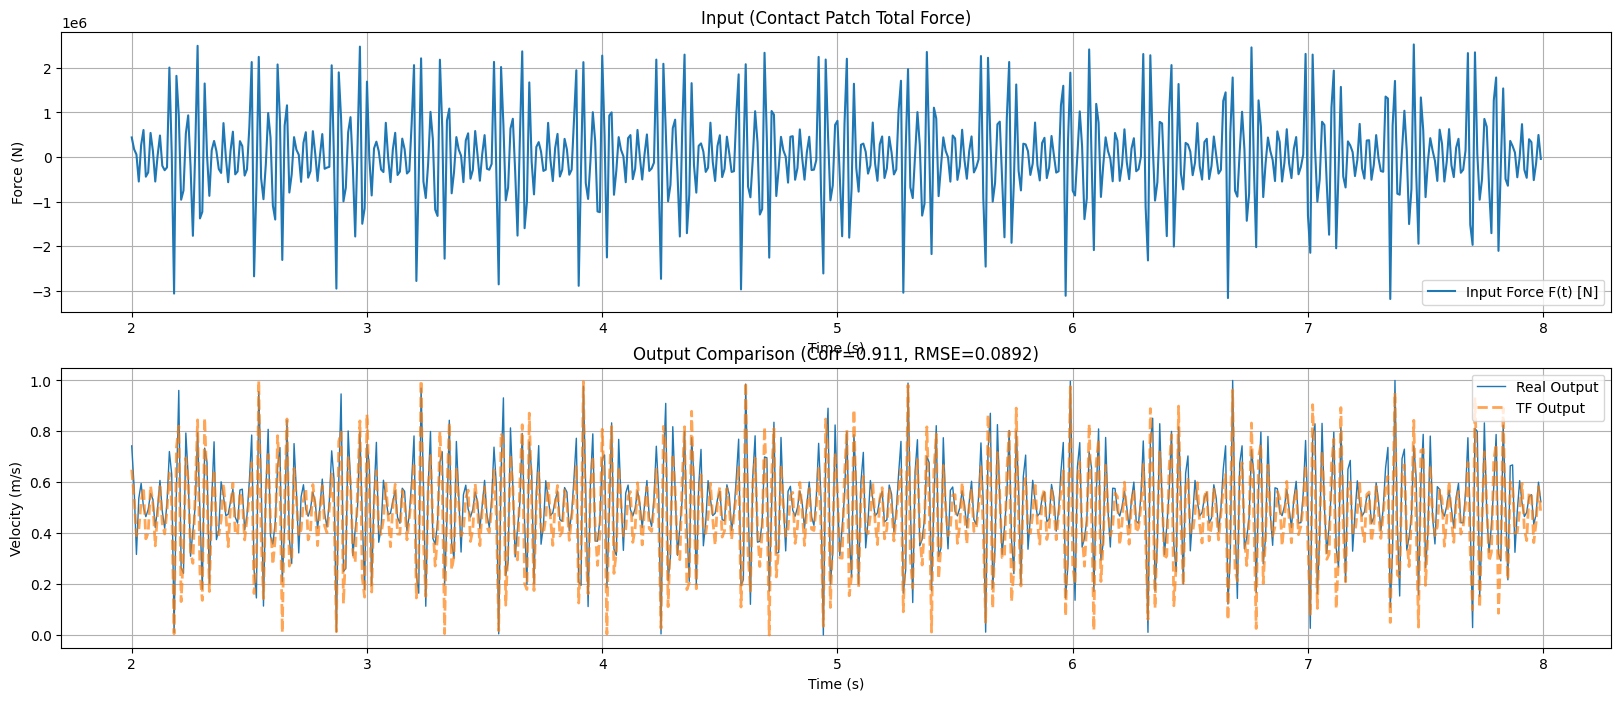

In [24]:
fs = 100.0
T = 10.0
t = np.linspace(0, T, int(T * fs), endpoint=False)

sel = 19
# sel = 2
force_input = signal_before[sel]

model = BedPlateModel(Lx=2.0, Ly=1.5, E=12e9, h= 0.02, rho=700, damping_ratio=0.3, patch_size=(0.2, 0.2))
# model = BedPlateModel(Lx=2.0, Ly=0.9, E=12e9, h= 0.02, rho=700, damping_ratio=0.05, patch_size=(1.7, 0.8))
patch_center = (1.0, 0.5)   # (xc, yc)
pos_sensor   = (1.8, 0.1)   # (xo, yo)

freqs, Gmag, v_out = model.process_signal(force_input, fs, patch_center, pos_sensor, max_modes=6)

plt.figure(figsize=(20, 8))
start, end = 200, 800
plt.subplot(2, 1, 1)
plt.plot(t[start:end], force_input[start:end], label="Input Force F(t) [N]", alpha=1)
plt.title("Input (Contact Patch Total Force)")
plt.xlabel("Time (s)")
plt.ylabel("Force (N)")
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
# sig_sel = signal_before[sel]
sig_sel = force_input
shift = 0
sig_sel = signal_after[sel]/10000
sig_sel = np.roll(sig_sel, shift)

plt.plot(t[start:end], norm_ecg(sig_sel[start:end]), label="Real Output", linewidth=1)
plt.plot(t[start:end],norm_ecg((v_out[start:end]))*1, label="TF Output", linewidth=2, alpha=0.7, linestyle='--')

corr = np.corrcoef(norm_ecg(sig_sel[:]), norm_ecg(v_out[:]))[0, 1]
RMSE = np.sqrt(np.mean((norm_ecg(sig_sel[:]) - norm_ecg(v_out[:]))**2))

print(f"RMSE: {RMSE:.4f}")
print(f"Correlation Coefficient: {corr:.4f}")
plt.title(f"Output Comparison (Corr={corr:.3f}, RMSE={RMSE:.4f})")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.grid(True)
plt.legend()
plt.savefig('TF_vs_RealOutput_.pdf', dpi=300)




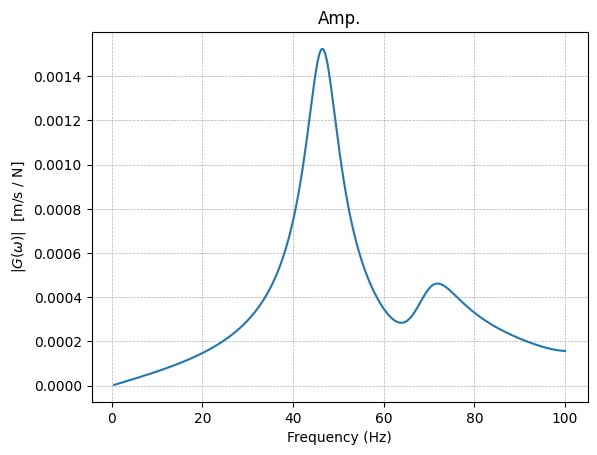

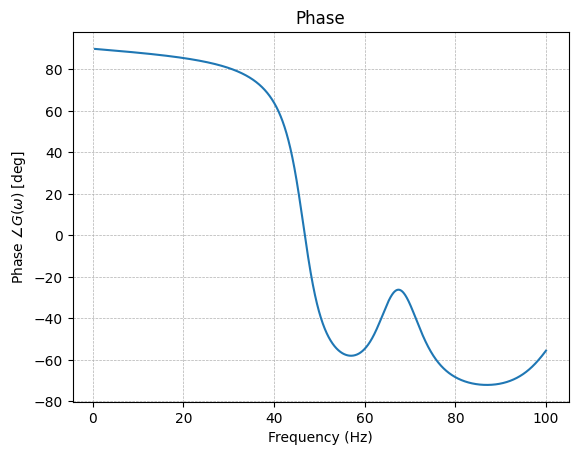

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1) Instantiate model
# -----------------------------
# model = BedPlateModel(Lx=2.0, Ly=1.5, E=12e9, h= 0.02, rho=700, damping_ratio=0.3, patch_size=(0.01, 0.01))
# model = BedPlateModel(Lx=2.0, Ly=1.5, E=12e9, h = 0.02, rho=600, damping_ratio=0.4, patch_size=(0.2, 0.2))
model = BedPlateModel(Lx=2.0, Ly=0.9, E=12e9, h= 0.02, rho=1100, damping_ratio=0.08, patch_size=(0.8, 0.6))
# model = BedPlateModel(Lx=2.0, Ly=1.0, h=0.02,E=12e9, rho=1000, nu=0.3, damping_ratio=0.1, patch_size=(0.2, 0.2))

# -----------------------------
# 2) Patch center & sensor position
# -----------------------------
# patch_center = (1.0, 0.5)   # (xc, yc)
# output_pos   = (1.8, 0.1)   # (xo, yo)

patch_center = (1.2, 0.45)   # (xc, yc)
output_pos   = (1.2, 0.45)   # (xo, yo)

# -----------------------------
# 3) Frequency range (0.5–100 Hz)
# -----------------------------
f_min = 0.5
f_max = 100.0
n_points = 3000

freqs = np.linspace(f_min, f_max, n_points)

# -----------------------------
# 4) Compute G(ω) = V/F
# -----------------------------
G = model.compute_transfer_function(
    freqs=freqs,
    patch_center=patch_center,
    output_pos=output_pos,
    max_modes=10
)

G_mag   = np.abs(G)                 # linear magnitude
G_phase = np.unwrap(np.angle(G))    # radians

# -----------------------------
# 5) Amplitude plot (linear scale)
# -----------------------------
plt.figure()
plt.plot(freqs, G_mag)
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$|G(\omega)|$  [m/s / N]")
plt.title("Amp.")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

# -----------------------------
# 6) Phase plot
# -----------------------------
plt.figure()
plt.plot(freqs, G_phase * 180.0 / np.pi)
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"Phase $\angle G(\omega)$ [deg]")
plt.title("Phase")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


Text(0, 0.5, 'FFT Amplitude')

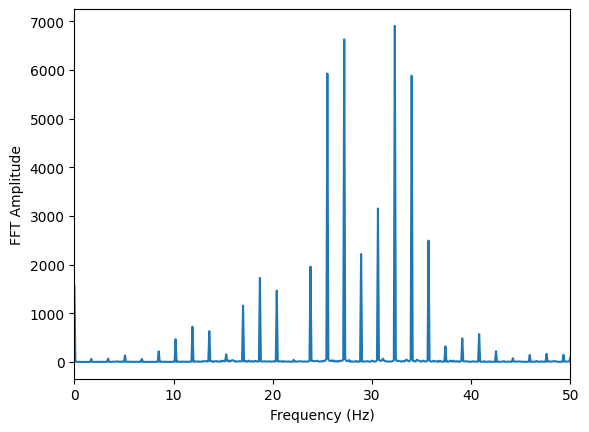

In [20]:
# draw FFT for sig_sel
from scipy.fft import rfft, rfftfreq
N = len(sig_sel)
yf = rfft(sig_sel)
xf = rfftfreq(N, 1 / fs)
plt.figure()
plt.plot(xf, np.abs(yf))
plt.xlim(0, 50)
plt.xlabel("Frequency (Hz)")
plt.ylabel("FFT Amplitude")

Text(0, 0.5, 'PSD')

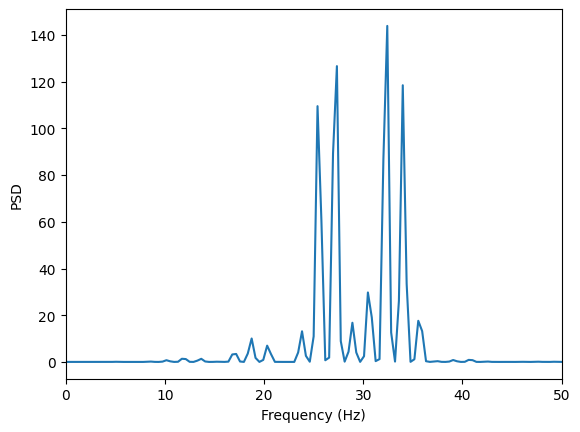

In [21]:
# draw PSD for sig_sel
from scipy.signal import welch
f, Pxx = welch(sig_sel, fs, nperseg=256)
plt.figure()
plt.plot(f, Pxx)
plt.xlim(0, 50)
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD")